In [85]:
import os
from pathlib import Path
import json

def get_last_file_in_directory(directory_path):
    # Get all files in the directory
    files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

    # Sort the files by modification time
    files.sort(key=lambda x: os.path.getmtime(os.path.join(directory_path, x)))

    # Return the last file in the list
    return files[-1] if files else None

def get_latest_files_in_subdirectories(directory_path):
    latest_files = []
    for subdir in os.scandir(directory_path):
        if subdir.is_dir():
            latest_file = get_last_file_in_directory(subdir.path)
            if latest_file is not None:
                latest_files.append((subdir.path, latest_file))
    return latest_files

In [95]:
from typing import Optional, Dict, List, Union
from pydantic import BaseModel, Field

class Metrics(BaseModel):
    difficulty: str
    success: bool
    success_percent: float = Field(..., alias="success_%")
    run_time: Optional[str] = None
    fail_reason: Optional[str] = None

class MetricsOverall(BaseModel):
    run_time: str
    highest_difficulty: str
    percentage: Optional[float] = None

class Test(BaseModel):
    data_path: str
    is_regression: bool
    answer: str
    description: str
    metrics: Metrics
    category: List[str]
    task: Optional[str] = None
    reached_cutoff: Optional[bool] = None

class SuiteTest(BaseModel):
    data_path: str
    metrics: MetricsOverall
    tests: Dict[str, Test]
    category: Optional[List[str]] = None
    task: Optional[str] = None
    reached_cutoff: Optional[bool] = None

class Report(BaseModel):
    command: str
    completion_time: str
    benchmark_start_time: str
    metrics: MetricsOverall
    tests: Dict[str, Union[Test, SuiteTest]]
    config: Dict[str, str]


In [99]:
reports_path = Path.cwd().parent / 'reports'

latest_files = get_latest_files_in_subdirectories(reports_path)
print(latest_files)

reports_data = {}

# This will print the latest file in each subdirectory and add to the files_data dictionary
for subdir, file in latest_files:
    subdir_name = os.path.basename(os.path.normpath(subdir))
    print(f"Subdirectory: {subdir}, Latest file: {file}")
    if subdir_name not in ["beebot", "mini-agi"]:
        continue
    with open(Path(subdir) / file, 'r') as f:
        # Load the JSON data from the file
        json_data = json.load(f)
        converted_data = Report.parse_obj(json_data)
        # get the last directory name in the path as key
        reports_data[subdir_name] = converted_data

[('c:\\Users\\silen\\Desktop\\Untitled Folder\\Projects\\Auto-GPT\\Auto-GPT-Benchmarks\\reports\\Auto-GPT', 'file55_07-29-10-45.json'), ('c:\\Users\\silen\\Desktop\\Untitled Folder\\Projects\\Auto-GPT\\Auto-GPT-Benchmarks\\reports\\BabyAGI', 'file40_07-29-10-47.json'), ('c:\\Users\\silen\\Desktop\\Untitled Folder\\Projects\\Auto-GPT\\Auto-GPT-Benchmarks\\reports\\beebot', 'file43_07-29-17-22.json'), ('c:\\Users\\silen\\Desktop\\Untitled Folder\\Projects\\Auto-GPT\\Auto-GPT-Benchmarks\\reports\\gpt-engineer', 'file53_07-29-10-45.json'), ('c:\\Users\\silen\\Desktop\\Untitled Folder\\Projects\\Auto-GPT\\Auto-GPT-Benchmarks\\reports\\mini-agi', 'file79_07-29-14-18.json'), ('c:\\Users\\silen\\Desktop\\Untitled Folder\\Projects\\Auto-GPT\\Auto-GPT-Benchmarks\\reports\\smol-developer', 'file54_07-29-10-45.json')]
Subdirectory: c:\Users\silen\Desktop\Untitled Folder\Projects\Auto-GPT\Auto-GPT-Benchmarks\reports\Auto-GPT, Latest file: file55_07-29-10-45.json
Subdirectory: c:\Users\silen\Desktop

In [94]:
STRING_DIFFICULTY_MAP = {
    "interface": 1,
    "basic": 2,
    "novice": 3,
    "intermediate": 4,
    "advanced": 5,
    "expert": 6,
    "human": 7,
}

In [100]:
from typing import Any

def get_agent_category(report: Report) -> dict[str, Any]:
    categories: dict[str, Any] = {}
    
    def get_highest_category_difficulty(data) -> None:
        for category in data.category:
            if category == "interface":
                continue
            num_dif = STRING_DIFFICULTY_MAP[data.metrics.difficulty]
            if num_dif > categories.setdefault(category, 0):
                categories[category] = num_dif

    for _, test_data in report.tests.items():
        suite = False

        if isinstance(test_data, SuiteTest):
            for _, test_data in test_data.tests.items():
                get_highest_category_difficulty(test_data)
        else:
            get_highest_category_difficulty(test_data)
            
    return categories

all_categories: dict[str, Any] = {}
 
for name, report in reports_data.items():
    categories = get_agent_category(report)
    all_categories[name] = categories
                        
print(all_categories)
        

{'beebot': {'content_gen': 2, 'safety': 4, 'memory': 5, 'code': 5, 'iterate': 5, 'retrieval': 4, 'adaptability': 4}, 'mini-agi': {'content_gen': 2, 'safety': 4, 'memory': 5, 'code': 5, 'iterate': 5, 'retrieval': 4, 'adaptability': 4}}


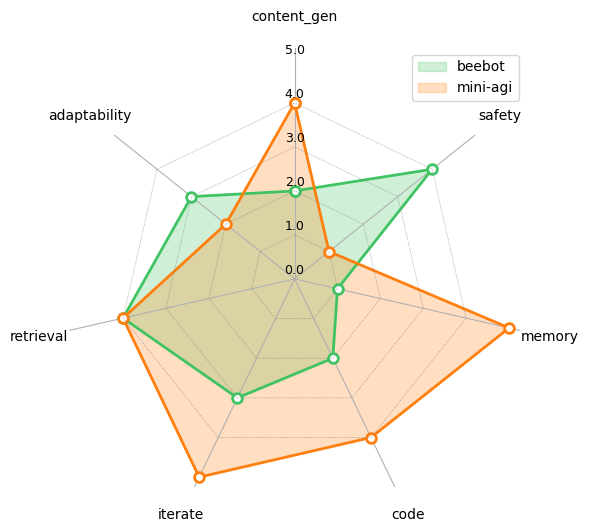

In [114]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker


def draw_radar_chart(categories):

    labels=np.array(list(next(iter(categories.values())).keys())) # We use the first category to get the keys
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1] # Add the first angle to the end of the list to ensure the polygon is closed

    # Create radar chart
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.spines['polar'].set_visible(False) # Remove border

    # Define a custom normalization to start the color from the middle
    norm = Normalize(vmin=0, vmax=max([max(val.values()) for val in categories.values()])) # We use the maximum of all categories for normalization

    colors = ['#40c463', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'] # Define more colors for more categories

    for i, (cat_name, cat_values) in enumerate(categories.items()): # Iterating through each category (series)
        values=np.array(list(cat_values.values()))
        values = np.concatenate((values, values[:1])) # Ensure the polygon is closed

        ax.fill(angles, values, color=colors[i], alpha=0.25) # Draw the filled polygon
        ax.plot(angles, values, color=colors[i], linewidth=2) # Draw polygon
        ax.plot(angles, values, 'o', color='white', markersize=7, markeredgecolor=colors[i], markeredgewidth=2) # Draw points

        # Draw legend
        ax.legend(handles=[mpatches.Patch(color=color, label=cat_name, alpha=0.25) for cat_name, color in zip(categories.keys(), colors)])

    lines, labels = plt.thetagrids(np.degrees(angles[:-1]), (list(next(iter(categories.values())).keys()))) # We use the first category to get the keys

    # Move labels away from the plot
    for label in labels:
        label.set_position((label.get_position()[0], label.get_position()[1] + -0.05))  # adjust 0.1 as needed

    ax.set_rlabel_position(180) # Move radial labels away from the plot
    
    ax.set_yticks([]) # Remove default yticks

    # Manually create gridlines
    for y in np.arange(0, norm.vmax + 1, 1):
        if y != norm.vmax:
            ax.plot(angles, [y] * len(angles), color='gray', linewidth=0.5, linestyle=':')
        # Add labels for manually created gridlines
        ax.text(angles[0], y + 0.2, str(int(y)), color='black', size=9, horizontalalignment='center', verticalalignment='center')

    plt.show()

# Here is how you can use the function
categories = {
    'beebot': {'content_gen': 2, 'safety': 4, 'memory': 1, 'code': 2, 'iterate': 3, 'retrieval': 4, 'adaptability': 3}, 
    'mini-agi': {'content_gen': 4, 'safety': 1, 'memory': 5, 'code': 4, 'iterate': 5, 'retrieval': 4, 'adaptability': 2}
}
draw_radar_chart(categories)

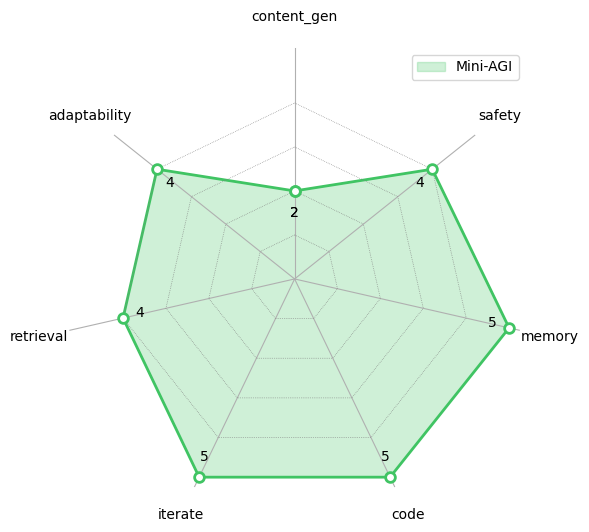

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize

# Define labels and values
categories = {'content_gen': 2, 'safety': 4, 'memory': 5, 'code': 5, 'iterate': 5, 'retrieval': 4, 'adaptability': 4}
labels=np.array(list(categories.keys()))
values=np.array(list(categories.values()))

# Number of variables
num_vars = len(labels)

# Compute angle each bar is centered on:
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Add the first angle to the end of the list to ensure the polygon is closed
angles += angles[:1]
values = np.concatenate((values, values[:1]))

# Define colors
colors = ['#40c463']

# Create radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Remove border
ax.spines['polar'].set_visible(False)

# Draw polygon
lines, labels = plt.thetagrids(np.degrees(angles[:-1]), (list(categories.keys())))

# Move labels away from the plot
for label in labels:
    label.set_position((label.get_position()[0], label.get_position()[1] + -0.05))  # adjust 0.1 as needed

# Define a custom normalization to start the color from the middle
norm = Normalize(vmin=0, vmax=values.max())

# Draw the filled polygon
ax.fill(angles, values, color=colors[0], alpha=0.25)
ax.plot(angles, values, color=colors[0], linewidth=2)

# Draw ylabels
for i, (angle, value) in enumerate(zip(angles, values)):
    ha = 'left'
    if angle in {0, np.pi}:
        ha = 'center'
    elif np.pi < angle < 2*np.pi:
        ha = 'right'
    ax.text(angle, value - 0.5, f'{value}', size=10, horizontalalignment=ha, verticalalignment="center", 
            color='black')

# Move radial labels away from the plot
ax.set_rlabel_position(180)

# Remove radial labels
ax.set_yticklabels([])

# Remove default yticks
ax.set_yticks([])

# Manually create gridlines
for y in np.arange(0, values.max(), 1):
    ax.plot(angles, [y] * len(angles), color='gray', linewidth=0.5, linestyle=':')

# Draw points
for angle, value in zip(angles, values):
    ax.plot(angle, value, 'o', color='white', markersize=7, markeredgecolor=colors[0], markeredgewidth=2)

# Draw legend
green_patch = mpatches.Patch(color='#40c463', label='Mini-AGI', alpha=0.25)
plt.legend(handles=[green_patch])

plt.show()